In [1]:
!pip install torch torchvision torchaudio
!pip install rdkit-pypi
!pip install transformers
!pip install datasets
!pip install safe-mol
!pip install molfeat

  Using cached molfeat-0.10.0-py3-none-any.whl.metadata (10 kB)
Using cached molfeat-0.10.0-py3-none-any.whl (164 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 3.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.10.0
    Uninstalling fsspec-2023.10.0:
      Successfully uninstalled fsspec-2023.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.17.1 requires fsspec[http]<=2023.10.0,>=2023.1.0, but you have fsspec 2024.2.0 which is incompatible.


In [24]:
import pandas as pd
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [25]:
zinc_data_path = './zinc250k.csv'
zinc_df = pd.read_csv(zinc_data_path)

zinc_df.head()

,smiles,qed,sa,parp1,fa7,5ht1b,braf,jak2
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,0.702012,0.879545,8.9,7.2,9.4,9.6,8.5
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,0.928975,0.729777,8.6,7.9,8.6,9.1,8.3
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,0.599682,0.836596,9.7,7.8,10.1,10.2,8.6
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,0.690944,0.797472,9.9,7.6,9.9,9.7,9.2
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,0.789027,0.662758,9.4,7.8,6.3,7.9,8.7


## Convert SMILES to SAFE

In [26]:
import safe as sf
import datamol as dm

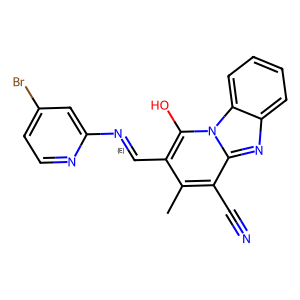

In [27]:
celecoxib = zinc_df['smiles'][8]
celecoxib_mol = dm.to_mol(celecoxib)

display(dm.to_image(celecoxib_mol))

In [28]:
safe_str = sf.encode(celecoxib_mol, canonical=True, slicer='attach')

print(safe_str)
print(f"Representation using {len(safe_str.split('.'))} fragments")


c14c9c%19n2c(nc3c%12c%22c8c6c32)c1%13.c1%11nc%23c%20c%16c1%18.C4%217%14.C=%179%10.N=%17%11.O%15%19.C#5%13.Br%16.N#5.[H]7.[H]%14.[H]%21.[H]%10.[H]%18.[H]%20.[H]%23.[H]%15.[H]%12.[H]%22.[H]8.[H]6
Representation using 21 fragments


In [29]:
# Add 'safe' column to dataframe and convert smiles to safe
# zinc_df['safe'] = zinc_df['smiles'].apply(lambda x: sf.encode(dm.to_mol(x), canonical=True, slicer='attach'))

In [30]:
# Use a smaller piece of the dataset for the sake of time
zinc_df_small = zinc_df.head(1000).copy()
zinc_df_small['safe'] = zinc_df_small['smiles'].apply(lambda x: sf.encode(dm.to_mol(x), canonical=True, slicer='attach'))
zinc_df_small.head()

,smiles,qed,sa,parp1,fa7,5ht1b,braf,jak2,safe
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,0.702012,0.879545,8.9,7.2,9.4,9.6,8.5,c1%20c%31c%17c2oc%14c%30c2c1%11.c1%27c%12c%18c...
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,0.928975,0.729777,8.6,7.9,8.6,9.1,8.3,[C@@]14%13C5%12C%26%27C%11%22[C@@]%32%17C1%28%...
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,0.599682,0.836596,9.7,7.8,10.1,10.2,8.6,N1%12C%14%22C%13%25C%34%17C16%27.c1%26c8c%18c%...
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,0.690944,0.797472,9.9,7.6,9.9,9.7,9.2,c15nc%16n2c1C%17%30C%14%32C%44%22C%26%13C2%41%...
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,0.789027,0.662758,9.4,7.8,6.3,7.9,8.7,C1%25=C%27N=C9[C@@]%294C12C%288C%31%20C%30%21C...


## Baseline: SAFE-gpt based on gpt2

In [31]:
designer = sf.SAFEDesign.load_default(verbose=True)

designer.model

SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)
    

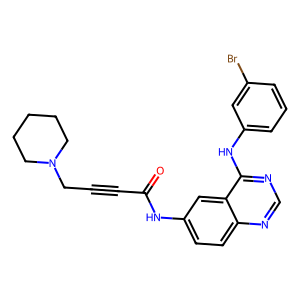

In [32]:
candidate_smiles = "O=C(C#CCN1CCCCC1)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1"
candidate_mol = dm.to_mol(candidate_smiles)

dm.to_image(candidate_mol)

## De novo generation - without constraints

In [33]:
generated_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=12)

generated_smiles[:5]

  0%|          | 0/1 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:433: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2024-02-27 19:12:20.657 | INFO     | safe.sample:de_novo_generation:577 - After sanitization, 11 / 12 (91.67 %) generated molecules are valid !


['COc1cccc(OC)c1C(=O)N1C[C@H]2COC[C@@H](C1)[C@H]2NC(=O)c1cnc(Cl)nc1',
 'N#Cc1ccnc(Sc2ccc(C(N)=O)cc2[N+](=O)[O-])c1',
 'CCN(CC)C(=O)c1ccccc1NC(=O)N[C@@H](C)c1ccc(Cl)cc1',
 'C[NH+]1CCN(c2ccc(NC(=O)c3coc(S(N)(=O)=O)c3)cc2Br)CC1',
 'CC(C)(CCCO)N=C(O)CC1(C(=O)O)CCCCC1']

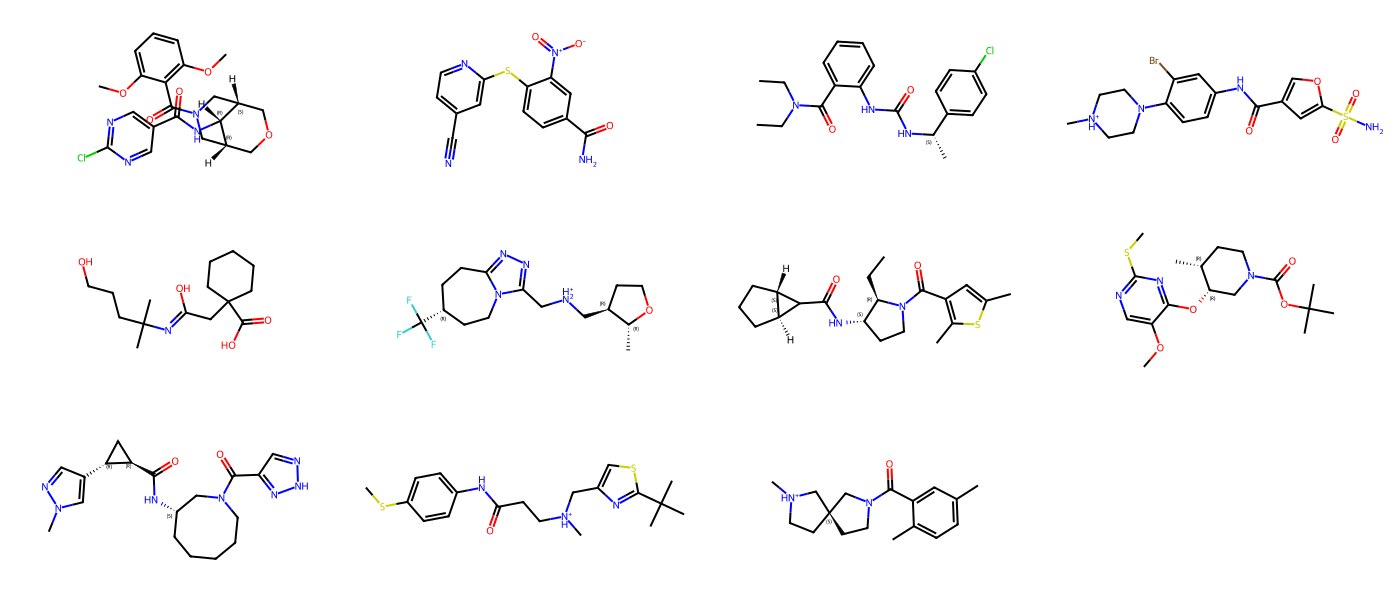

In [34]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))

## Scaffold Decoration - constraint of particular scaffold

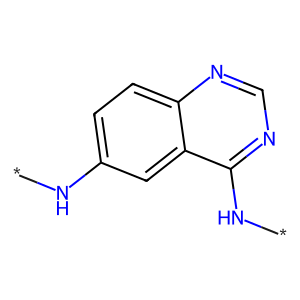

In [35]:
scaffold = "[*]N-c1ccc2ncnc(-N[*])c2c1"

dm.to_image(scaffold)


In [36]:
generated_smiles = designer.scaffold_decoration(
    scaffold=scaffold,
    n_samples_per_trial=12,
    n_trials=2,
    sanitize=True,
    do_not_fragment_further=True,
)

generated_mols = [dm.to_mol(x) for x in generated_smiles]

  0%|          | 0/2 [00:00<?, ?it/s]

2024-02-27 19:12:23.783 | INFO     | safe.sample:scaffold_decoration:538 - After sanitization, 23 / 24 (95.83 %)  generated molecules are valid !


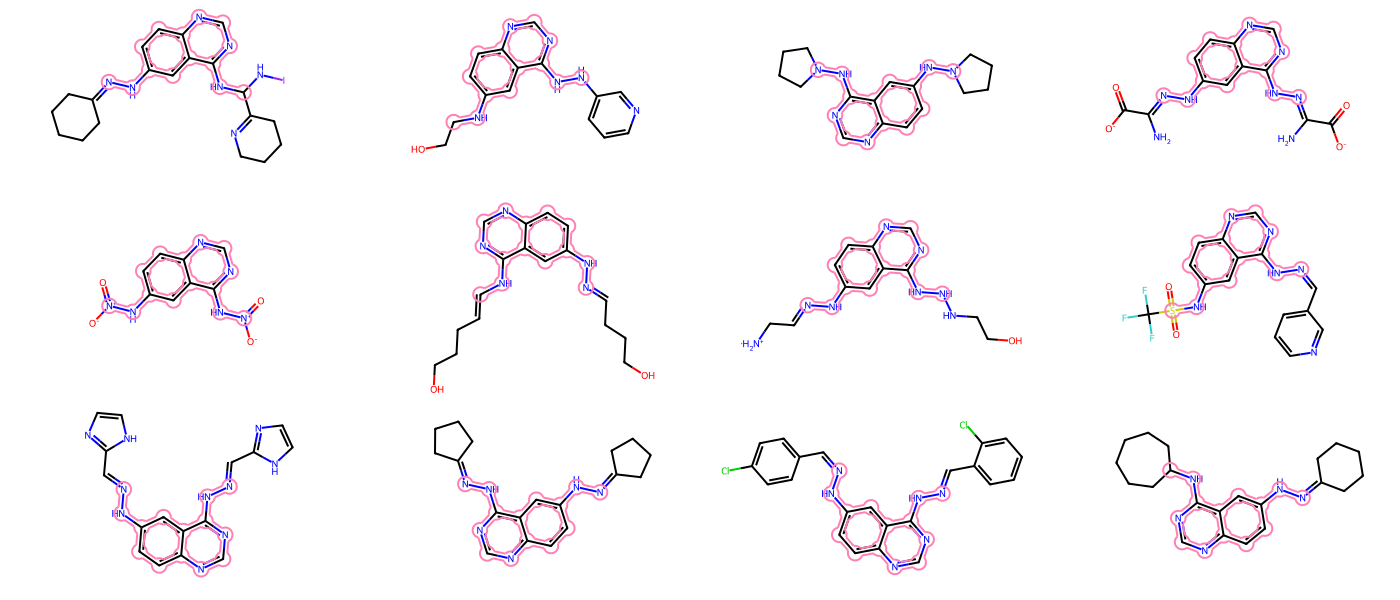

In [37]:
dm.viz.lasso_highlight_image(generated_mols[:12], dm.from_smarts(scaffold), mol_size=(350, 200), color_list=["#ff80b5"], scale_padding=0.1)

## Super structure generation - constraint of particular super structure

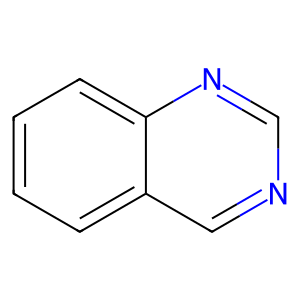

In [39]:
superstructure = "c1ccc2ncncc2c1"

dm.to_image(superstructure)

In [40]:
generated_smiles = designer.super_structure(
    core=superstructure,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    attachment_point_depth=3,
)

generated_smiles

  0%|          | 0/1 [00:00<?, ?it/s]

2024-02-27 19:13:54.457 | INFO     | safe.sample:super_structure:492 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['O=[N+]([O-])c1ccc2c([N+](=O)[O-])ncnc2c1[S+]([O-])c1cccs1',
 'FC(F)(F)c1ccc2c(C(F)(F)C(F)(F)F)ncnc2c1C(F)(F)F',
 'OCCOCCOc1ccc2c(C(F)(F)F)ncnc2c1C(F)(F)F',
 'FC(F)(F)c1ccc2c(C(F)(F)F)ncnc2c1C(F)(F)F',
 'FC(F)(F)c1ccc2c(C(F)(F)F)ncnc2c1C(F)(F)F',
 'FC(F)(F)c1ccc2c(C(F)(F)F)ncnc2c1C(F)(F)F',
 'NS(=O)(=O)c1ncnc2c([N+](=O)[O-])c([N+](=O)[O-])ccc12',
 'FC(F)Oc1ccc2c(-c3cccc4[nH]ncc34)ncnc2c1C(F)F',
 'OCC#Cc1ccc2c(C#CCO)ncnc2c1C#CCO',
 'FC(F)(F)c1ccc2c(C(F)(F)F)ncnc2c1C(F)(F)F',
 'FC(F)(F)c1ccc2c(N3CCCC3)ncnc2c1C(F)(F)F',
 'OCc1ccc2c(CO)ncnc2c1C(F)F']

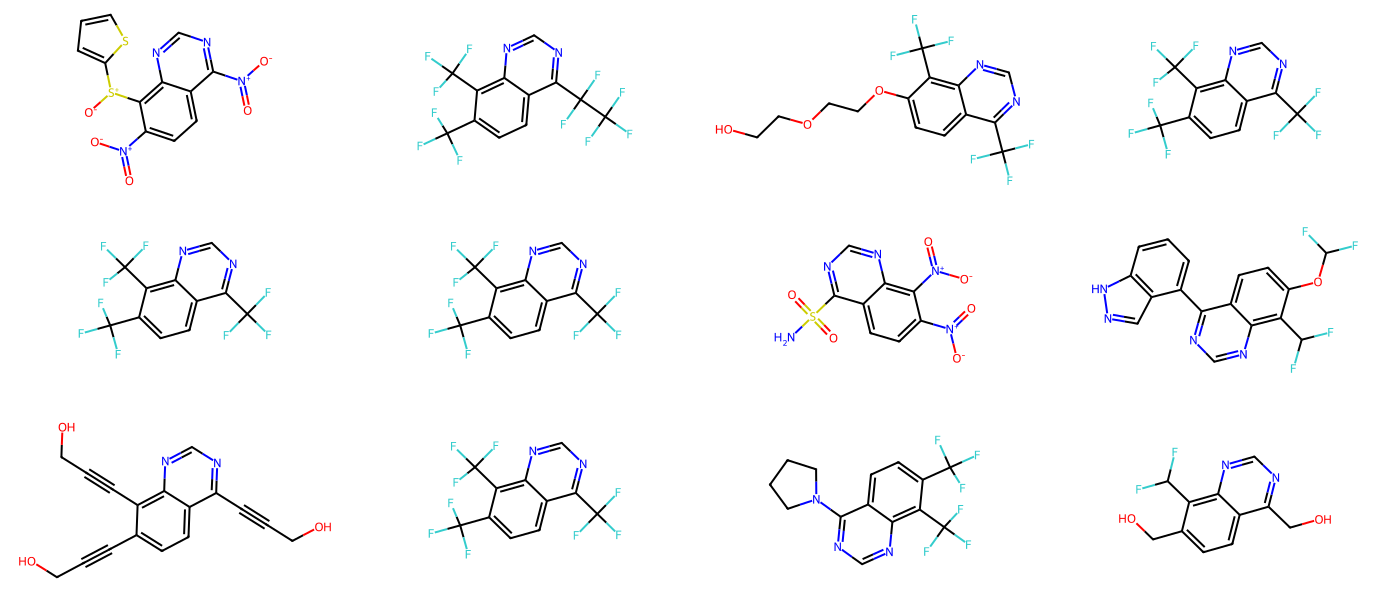

In [41]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))

## Motif Extension - constraint of particular motif

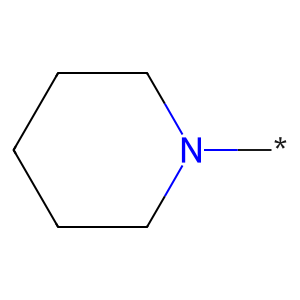

In [42]:
motif = "[*]-N1CCCCC1"

dm.to_image(motif)

In [43]:
# let's make some long sequence
generated_smiles = designer.motif_extension(
    motif=motif,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    min_length=25,
    max_length=80,
)

generated_smiles

  0%|          | 0/1 [00:00<?, ?it/s]

[19:14:33] WARNING: not removing hydrogen atom without neighbors
[19:14:33] WARNING: not removing hydrogen atom without neighbors
2024-02-27 19:14:33.034 | INFO     | safe.sample:scaffold_decoration:538 - After sanitization, 11 / 12 (91.67 %)  generated molecules are valid !


['N[C@@H](C(=O)O)N1CCCCC1.O=S(=O)(O)O',
 'NCC/N=N\\N1CCCCC1.O=S(=O)(O)O',
 'C1CCC([Si]([Cl+]N2CCCCC2)(C2CCCCC2)N2CCCCC2)CC1',
 'c1csc(NN2CCCCC2N2CCCCC2)n1',
 'O=C(O)O.O=[SH]CCN1CCCCC1',
 'O=C(O)O.O=[N+]([O-])/C=C/N1CCCCC1',
 'C1CCN(N2CCNCCNCCNCC2)CC1',
 'O=S(=O)(O)N1CCCCC1.[Al].[H].[H]',
 'NNNNNNNNNNNNC(N)N1CCCCC1',
 'O=C([O-])N1CCCCC1.[Li+].[Li+].[O].[Zn]',
 'O=C(CS)CCCCS[Se]CC(=O)CN1CCCCC1']

[19:14:39] WARNING: not removing hydrogen atom without neighbors
[19:14:39] WARNING: not removing hydrogen atom without neighbors


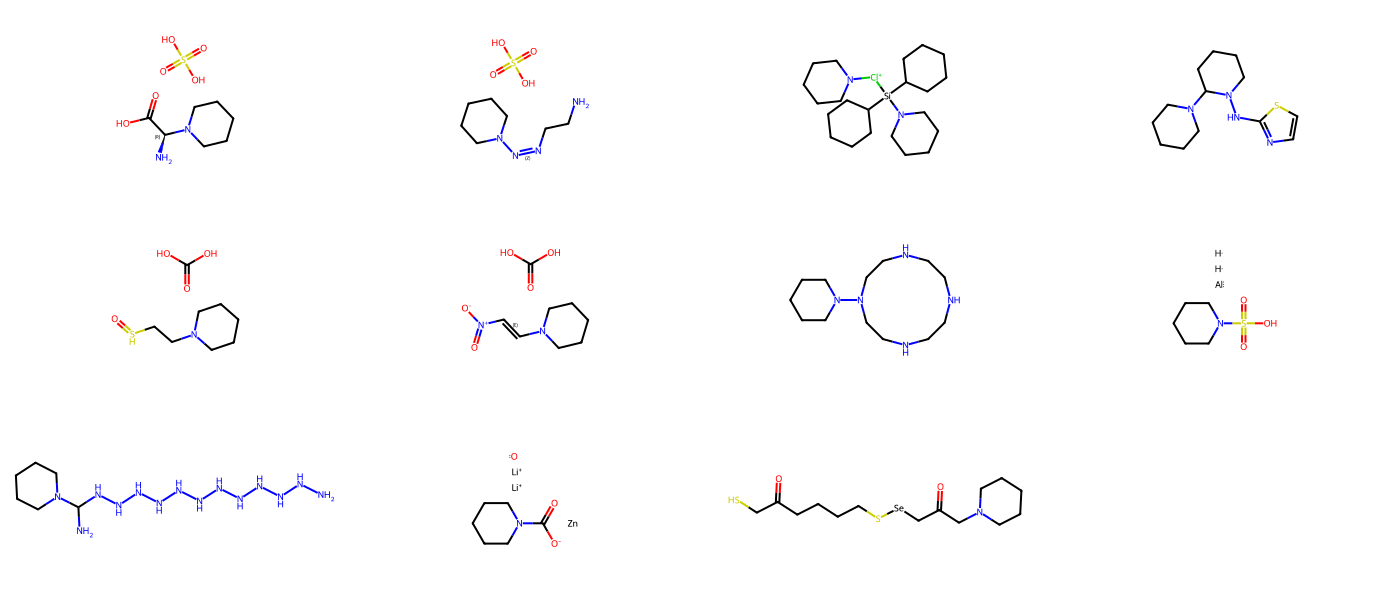

In [44]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))

## Scaffold Hopping - constraint of particular scaffold

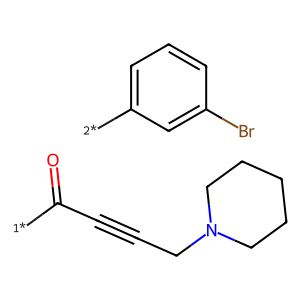

In [45]:
side_chains = "[1*]C(=O)C#CCN1CCCCC1.[2*]c1cccc(Br)c1"

dm.to_image(side_chains)

  0%|          | 0/1 [00:00<?, ?it/s]

2024-02-27 19:15:34.461 | INFO     | safe.sample:_fragment_linking:393 - After sanitization, 6 / 12 (50.00 %)  generated molecules are valid !


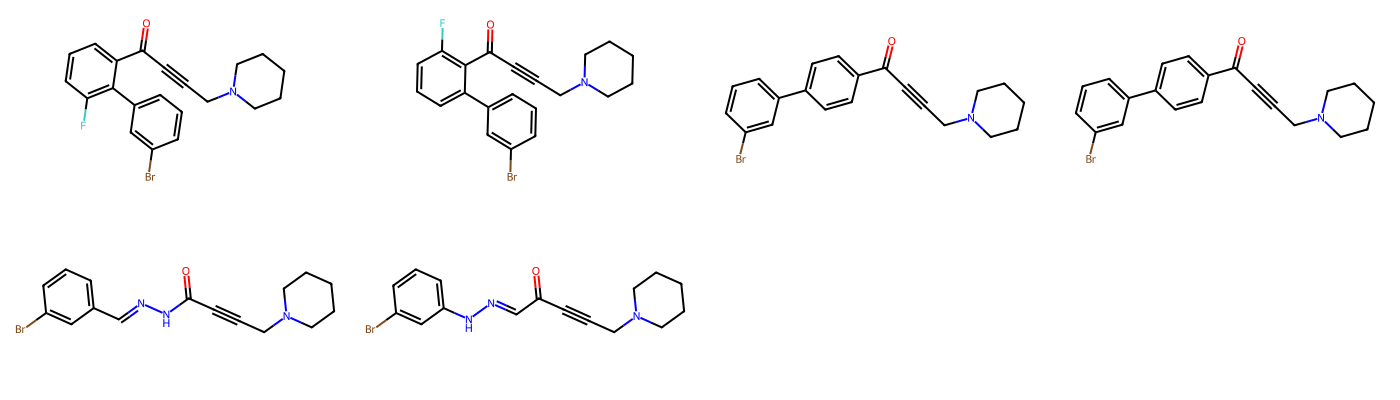

In [47]:
generated_smiles = designer.scaffold_morphing(
    side_chains=side_chains,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

dm.to_image(generated_smiles[:12], mol_size=(350, 200))

## Linker generation - constraint of particular linker

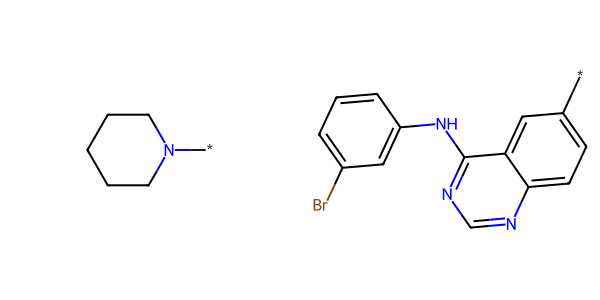

In [48]:
linker_generation = ["[*]-N1CCCCC1", "Brc1cccc(Nc2ncnc3ccc(-[*])cc23)c1"]

dm.to_image(linker_generation)

In [49]:
generated_smiles = designer.linker_generation(
    *linker_generation,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

generated_smiles


  0%|          | 0/1 [00:00<?, ?it/s]

2024-02-27 19:16:12.401 | INFO     | safe.sample:_fragment_linking:393 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['Brc1cccc(Nc2ncnc3ccc(C4CN(N5CCCCC5)CCO4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(N4CCOC(N5CCCCC5)C4)cc23)c1',
 'Fc1c2nc3cccc(N4CCCCC4)c3c-2c[nH]c1Cc1ccc2ncnc(Nc3cccc(Br)c3)c2c1',
 'Fc1c2nc3cccc(-c4ccc5ncnc(Nc6cccc(Br)c6)c5c4)c3c-2c[nH]c1CN1CCCCC1',
 'Brc1cccc(Nc2ncnc3ccc(C4=C(N5CCCCC5)CCC=C4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(C4=C(N5CCCCC5)C=CCC4)cc23)c1',
 'Nc1ncnc2[nH]c(=NCCCN3CCCCC3)n(CCNC(=O)c3ccc(-c4ccc5ncnc(Nc6cccc(Br)c6)c5c4)cc3)c12',
 'Nc1ncnc2[nH]c(=NCCCc3ccc4ncnc(Nc5cccc(Br)c5)c4c3)n(CCNC(=O)c3ccc(N4CCCCC4)cc3)c12',
 'Brc1cccc(Nc2ncnc3ccc(-c4cccc(OCN5CCCCC5)c4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(COc4cccc(N5CCCCC5)c4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(C4CCCC4Sc4ccccc4CCSN4CCCCC4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(SCCc4ccccc4SC4CCCC4N4CCCCC4)cc23)c1']

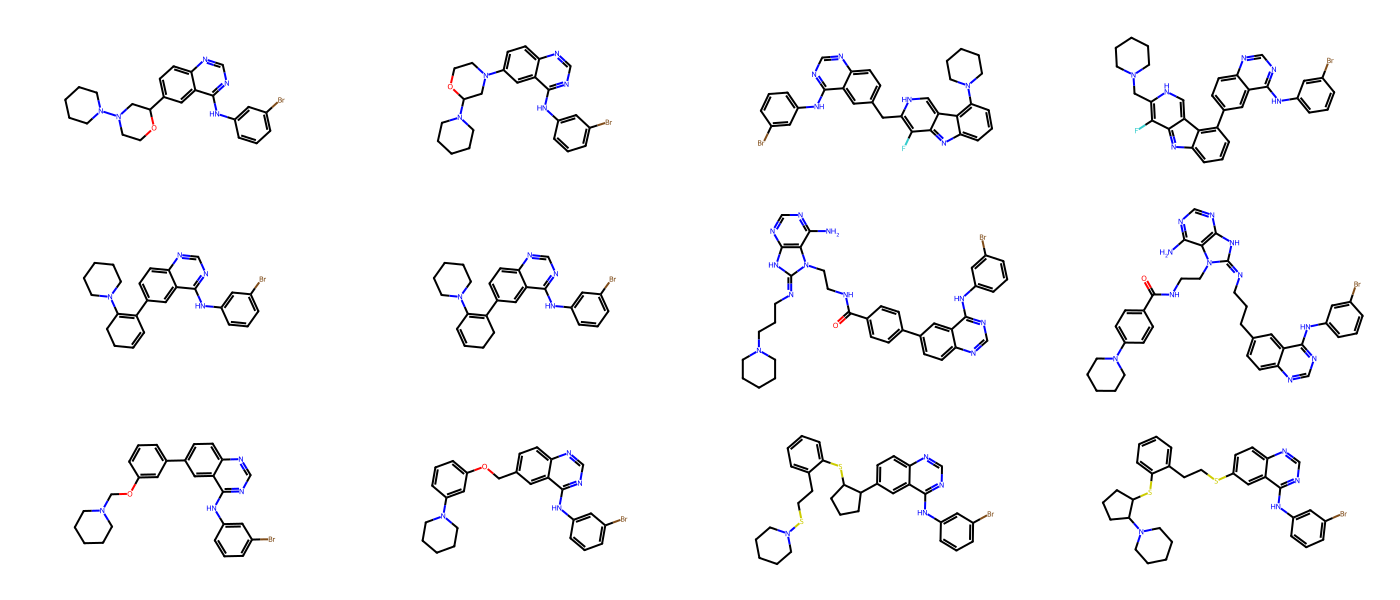

In [50]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))